### Imagic implementation for Diffusers

This implementation isd heavily based on [Justin Pinkey's Notebook](https://github.com/justinpinkney/stable-diffusion/blob/main/notebooks/imagic.ipynb)

In [22]:
from PIL import Image
import torch
from PIL import Image
import matplotlib.pyplot as plt
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler
from torchvision import transforms
import logging
from tqdm.auto import tqdm
import functools

logging.disable(logging.WARNING)

DEVICE = "cuda:1"

In [40]:
def _to_image(x:torch.Tensor) -> Image.Image:
    image = (x / 2 + 0.5).clamp(0, 1)
    image = image[0].detach().cpu().permute(1, 2, 0).numpy()
    image = (image * 255).round().astype("uint8")
    return Image.fromarray(image)


def _latent_to_image(vae:AutoencoderKL, latents:torch.Tensor) -> Image.Image:
    with torch.no_grad():
        image = vae.decode(1 / 0.18215 * latents).sample
    return _to_image(image)

def _simple_tokenize(tokenizer:CLIPTokenizer, prompt:str):
    return tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")['input_ids']

def _embed_tokens(encoder:CLIPTextModel, tokens:torch.Tensor):
    return encoder(tokens.to(DEVICE))[0]

def _generate(scheduler:LMSDiscreteScheduler, unet:UNet2DConditionModel, embed_fn, prompt:str, guidance_scale = 7.5, height = 512, width = 512, batch_size = 1):

    text_emb = embed_fn(prompt)
    uncond_emb = embed_fn([""] * batch_size)
    text_embeddings = torch.cat([uncond_emb, text_emb])

    latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8)).to(DEVICE)
    latents = latents * scheduler.init_noise_sigma
    
    for i, t in enumerate(tqdm(scheduler.timesteps)):
        input = torch.cat([latents] * 2)
        input = scheduler.scale_model_input(input, t)

        # predict the noise residual
        with torch.no_grad(): 
            pred = unet(input, t, encoder_hidden_states=text_embeddings).sample

        # perform guidance
        pred_uncond, pred_text = pred.chunk(2)
        pred = pred_uncond + guidance_scale * (pred_text - pred_uncond)

        # compute the "previous" noisy sample
        latents = scheduler.step(pred, t, latents).prev_sample

    return latents

def load_img(path, target_size=512):
    """Load an image, resize and output -1..1"""
    image = Image.open(path).convert("RGB")
    
    
    tform = transforms.Compose([
            transforms.Resize(target_size),
            transforms.CenterCrop(target_size),
            transforms.ToTensor(),
        ])
    image = tform(image)
    return 2.*image - 1.

In [35]:
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14").to(DEVICE)
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae").to(DEVICE)
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet").to(DEVICE)

beta_start, beta_end = 0.00085, 0.012
scheduler = LMSDiscreteScheduler(beta_start=beta_start, beta_end=beta_end, beta_schedule="scaled_linear", num_train_timesteps=64)

In [41]:
latent_to_image = functools.partial(_latent_to_image, vae)
simple_tokenize = functools.partial(_simple_tokenize, tokenizer)
embed_tokens = functools.partial(_embed_tokens, text_encoder)
embed_prompt = lambda p: embed_tokens(simple_tokenize(p))
generate = functools.partial(_generate, scheduler, unet, embed_prompt)

  0%|          | 0/64 [00:00<?, ?it/s]

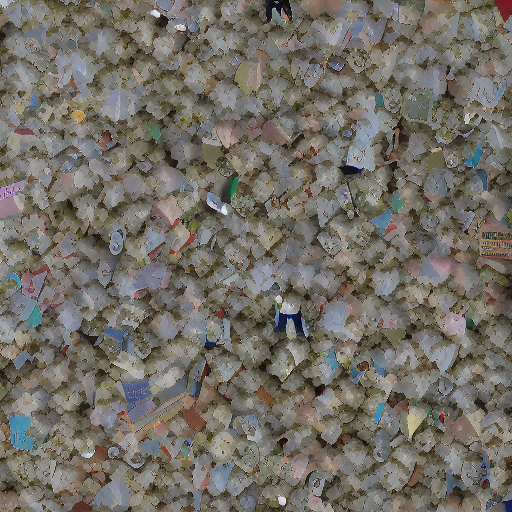

In [43]:
prompt = ["a photograph of Robin Williams with a large grin"]
init_image = load_img('images/robin_williams.jpg').to(DEVICE).unsqueeze(0)

orig_emb = embed_prompt(prompt)
emb = orig_emb.clone()

init_image = generate(prompt)
latent_to_image(init_image)

In [25]:
emb.requires_grad = True
lr = 0.001
it = 500
opt = torch.optim.Adam([emb], lr=lr)
criteria = torch.nn.MSELoss()
history = []

pbar = tqdm(range(it))
for i in pbar:
    opt.zero_grad()
    
    noise = torch.randn_like(init_latent)
    t_enc = torch.randint(1000, (1,), device=device)
    z = model.q_sample(init_latent, t_enc, noise=noise)
    
    pred_noise = model.apply_model(z, t_enc, emb)
    
    loss = criteria(pred_noise, noise)
    loss.backward()
    pbar.set_postfix({"loss": loss.item()})
    history.append(loss.item())
    opt.step()

1
